Jupyter notebook to test+demo the functionality of adaptivity in experiment design offered by Qinfer

In [1]:
# imports
from __future__ import division, print_function
%matplotlib inline

from qinfer import *
import os, sys, types
import pathlib
from importlib import reload
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [2]:
# For local package imports
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [3]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

In [4]:
import bayesianhl

# 1. Two-qubit Interaction

In [6]:
from bayesianhl.qinfer_system_models import SingleInteractionModel

## 1.1 Passive Learning

In [7]:
# Set up system model and updater
sys_model = BinomialModel(SingleInteractionModel())
prior = UniformDistribution([0, 1])
updater = SMCUpdater(sys_model, 2000, prior)

In [8]:
# True model
true_params = np.array([[0.3]])

In [9]:
# Parameters of experiment
tvec = np.linspace(1, 60, 81)
n_shots = 20
max_iters = 20 # Iterations of the learning

In [10]:
# Passive learning -- say max_iters of n_shots against all in tvec
est_hist = []
error_hist = []
nshots_hist = []

np.random.seed(2021)

nshots_cumulative = 0
for ind_iter in range(max_iters):
    for t in tvec:
        experiment = np.array([(t, n_shots)], dtype=sys_model.expparams_dtype)
        outcomes = sys_model.simulate_experiment(true_params, experiment)
        
        # update quantities
        updater.update(outcomes, experiment)
        nshots_cumulative += n_shots
        
    _Jhat = updater.est_mean()
    est_hist.append(_Jhat)
    error_hist.append(np.abs(_Jhat - true_params[0]))
    nshots_hist.append(nshots_cumulative)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  # This is added back by InteractiveShellApp.init_path()


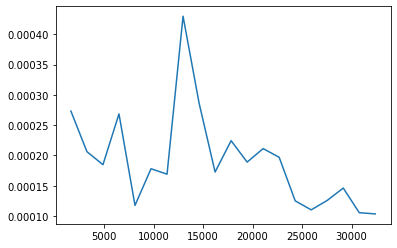

In [11]:
plt.plot(nshots_hist, error_hist)

Text(0, 0.5, '$\\omega$')

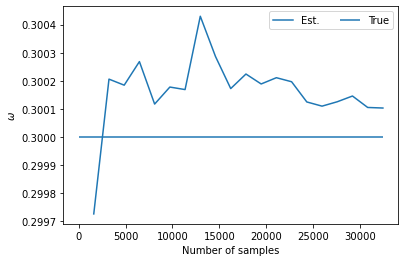

In [12]:
plt.plot(nshots_hist, est_hist, label='Est.')
plt.hlines(true_params, 0, nshots_hist[-1], label='True')
plt.legend(ncol=2)
plt.xlabel('Number of samples')
plt.ylabel(r'$\omega$')

### Can we evaluate the Baye's risk

In [13]:
child_sys_model = SingleInteractionModel()
risk_updater = SMCUpdater(child_sys_model, 2000, prior)

In [14]:
n_mps = risk_updater.model.base_model.n_modelparams

In [15]:
locs = updater.particle_locations[:,:n_mps]
weights = updater.particle_weights

In [16]:
risk_updater.particle_locations = locs
risk_updater.particle_weights = weights

In [17]:
risk = []
for t in tvec:
    risk.append(risk_updater.bayes_risk({'time': t}))

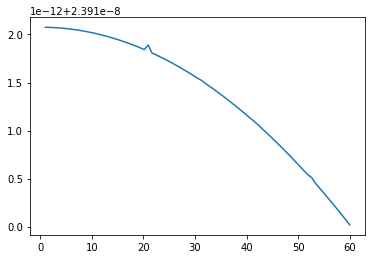

In [18]:
plt.plot(tvec, risk)

### What would be the best experiment (time) to measure now?

In [72]:
np.argmin(risk)

80

# 2. Noisy CR Hamiltonians

In [20]:
from bayesianhl.qinfer_cr_hamiltonians import NoisyCRHamiltonian

In [21]:
# Define quantum system model
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

sys_model = BinomialModel(NoisyCRHamiltonian(xi_J=xi_J, xi_t=xi_t, FLAG_control_noise=True))

In [7]:
# Define the true parameters
J_truth = np.array([[-4610290.4944338, -1479956.7612268,  -229800.80519662,
                    6608520.58971551,  1460516.49322424,   336451.01484356]])

# This is what we will actually run with -- non-dimensional parameters 
J_truth_nd = J_truth/xi_J

In [8]:
# Note that we have all components within [-10,10]
J_truth_nd

array([[-4.61029049, -1.47995676, -0.22980081,  6.60852059,  1.46051649,
         0.33645101]])

In [9]:
# Lets try this with an estimator
Jmin = -10
Jmax = 10
n_particles = 5000

prior = UniformDistribution([[Jmin, Jmax]]*n_J)
updater = SMCUpdater(sys_model, n_particles, prior)

In [10]:
# Define the experiments
tvec = np.linspace(1, 6, 81)
mvec = [0, 1, 2]
uvec = [0, 1]

n_shots = 10

In [11]:
# Multiple shots at each (M, U, t)
est_hist = []
cum_shots = []

cum_shots_counter = 0
for t in tvec:
    for m in mvec:
        for u in uvec:
            experiment = np.array([(m, u, t, n_shots)], dtype=sys_model.expparams_dtype)
            outcomes = sys_model.simulate_experiment(J_truth_nd, experiment)
            updater.update(outcomes, experiment)
            
            cum_shots_counter += n_shots
    
            print('Done with (m,u,t) = (%d, %d, %f)' %(m, u, t))
    
    est_hist.append(updater.est_mean())
    cum_shots.append(cum_shots_counter)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if __name__ == '__main__':
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done with (m,u,t) = (0, 0, 1.000000)
Done with (m,u,t) = (0, 1, 1.000000)
Done with (m,u,t) = (1, 0, 1.000000)
Done with (m,u,t) = (1, 1, 1.000000)
Done with (m,u,t) = (2, 0, 1.000000)
Done with (m,u,t) = (2, 1, 1.000000)
Done with (m,u,t) = (0, 0, 1.062500)
Done with (m,u,t) = (0, 1, 1.062500)
Done with (m,u,t) = (1, 0, 1.062500)
Done with (m,u,t) = (1, 1, 1.062500)
Done with (m,u,t) = (2, 0, 1.062500)
Done with (m,u,t) = (2, 1, 1.062500)
Done with (m,u,t) = (0, 0, 1.125000)
Done with (m,u,t) = (0, 1, 1.125000)
Done with (m,u,t) = (1, 0, 1.125000)
Done with (m,u,t) = (1, 1, 1.125000)
Done with (m,u,t) = (2, 0, 1.125000)
Done with (m,u,t) = (2, 1, 1.125000)
Done with (m,u,t) = (0, 0, 1.187500)
Done with (m,u,t) = (0, 1, 1.187500)
Done with (m,u,t) = (1, 0, 1.187500)
Done with (m,u,t) = (1, 1, 1.187500)
Done with (m,u,t) = (2, 0, 1.187500)
Done with (m,u,t) = (2, 1, 1.187500)
Done with (m,u,t) = (0, 0, 1.250000)
Done with (m,u,t) = (0, 1, 1.250000)
Done with (m,u,t) = (1, 0, 1.250000)
D

Done with (m,u,t) = (0, 0, 3.312500)
Done with (m,u,t) = (0, 1, 3.312500)
Done with (m,u,t) = (1, 0, 3.312500)
Done with (m,u,t) = (1, 1, 3.312500)
Done with (m,u,t) = (2, 0, 3.312500)
Done with (m,u,t) = (2, 1, 3.312500)
Done with (m,u,t) = (0, 0, 3.375000)
Done with (m,u,t) = (0, 1, 3.375000)
Done with (m,u,t) = (1, 0, 3.375000)
Done with (m,u,t) = (1, 1, 3.375000)
Done with (m,u,t) = (2, 0, 3.375000)
Done with (m,u,t) = (2, 1, 3.375000)
Done with (m,u,t) = (0, 0, 3.437500)
Done with (m,u,t) = (0, 1, 3.437500)
Done with (m,u,t) = (1, 0, 3.437500)
Done with (m,u,t) = (1, 1, 3.437500)
Done with (m,u,t) = (2, 0, 3.437500)
Done with (m,u,t) = (2, 1, 3.437500)
Done with (m,u,t) = (0, 0, 3.500000)
Done with (m,u,t) = (0, 1, 3.500000)
Done with (m,u,t) = (1, 0, 3.500000)
Done with (m,u,t) = (1, 1, 3.500000)
Done with (m,u,t) = (2, 0, 3.500000)
Done with (m,u,t) = (2, 1, 3.500000)
Done with (m,u,t) = (0, 0, 3.562500)
Done with (m,u,t) = (0, 1, 3.562500)
Done with (m,u,t) = (1, 0, 3.562500)
D

Done with (m,u,t) = (1, 1, 5.812500)
Done with (m,u,t) = (2, 0, 5.812500)
Done with (m,u,t) = (2, 1, 5.812500)
Done with (m,u,t) = (0, 0, 5.875000)
Done with (m,u,t) = (0, 1, 5.875000)
Done with (m,u,t) = (1, 0, 5.875000)
Done with (m,u,t) = (1, 1, 5.875000)
Done with (m,u,t) = (2, 0, 5.875000)
Done with (m,u,t) = (2, 1, 5.875000)
Done with (m,u,t) = (0, 0, 5.937500)
Done with (m,u,t) = (0, 1, 5.937500)
Done with (m,u,t) = (1, 0, 5.937500)
Done with (m,u,t) = (1, 1, 5.937500)
Done with (m,u,t) = (2, 0, 5.937500)
Done with (m,u,t) = (2, 1, 5.937500)
Done with (m,u,t) = (0, 0, 6.000000)
Done with (m,u,t) = (0, 1, 6.000000)
Done with (m,u,t) = (1, 0, 6.000000)
Done with (m,u,t) = (1, 1, 6.000000)
Done with (m,u,t) = (2, 0, 6.000000)
Done with (m,u,t) = (2, 1, 6.000000)


In [12]:
updater.est_mean()

array([-4.60672444, -1.48444763,  0.21032   ,  6.56716375,  1.52418453,
       -0.11325233])

In [13]:
J_truth_nd

array([[-4.61029049, -1.47995676, -0.22980081,  6.60852059,  1.46051649,
         0.33645101]])

## Define the risk taker

In [42]:
reload_package(bayesianhl)

In [43]:
from bayesianhl import BayesRiskHeuristic
from bayesianhl.action_space import ActionSpace
from bayesianhl.qinfer_cr_hamiltonians import NoisyCRHamiltonian

In [44]:
risk_sys_model = NoisyCRHamiltonian(xi_J=xi_J, xi_t=xi_t, FLAG_control_noise=True)
Q = np.ones(6)

In [45]:
# Define the action space
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

# Define query space
moset = [0,1,2]
prepset = [0,1]
time_stamps = np.linspace(1e-7, 6e-7, 81)
tset = time_stamps/xi_t

query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

A_cr = ActionSpace(moset, prepset, tset, xi_t, xi_J)

In [46]:
risk_heuristic = BayesRiskHeuristic(updater, risk_sys_model, Q, A_cr.action_space, prior)

In [47]:
q_expt, q_vec, risk = risk_heuristic.get_best_query(updater)

In [48]:
q_expt

array([[0.    , 1.    , 2.0625]])

In [50]:
np.argmax(q_vec)

103

# 3. Run a job with Bayes Risk + SMC

In [22]:
reload_package(bayesianhl)

In [23]:
from bayesianhl.qinfer_bayesian_learner import QinferExperimentRunner

## 3.1 Define ActionSpace

In [24]:
from bayesianhl.action_space import ActionSpace

In [25]:
# Define quantum system model
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

In [26]:
# Define query space
moset = [0,1,2]
prepset = [0,1]
time_stamps = np.linspace(1e-7, 6e-7, 81)
tset = time_stamps/xi_t

query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

In [27]:
A_cr = ActionSpace(moset, prepset, tset, xi_t, xi_J)

## 3.2 Setup run

In [28]:
# Set true values
J_truth = np.array([[-4568258.88132824, -1465045.02848701,  -290468.97835928,
                    6499545.9801579,  1390900.08768167,   413722.74870734]])

In [29]:
# Define quantum system model
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

In [30]:
# This is what we will actually run with -- non-dimensional parameters 
J_truth_nd = J_truth/xi_J

In [31]:
# Set up experiment runner

# Experiment parameters
N_0 = 5*A_cr.N_actions
N_batch = 2*A_cr.N_actions
max_iter = 5

# estimator relevant parameters
n_particles = 5000

learner_expt = QinferExperimentRunner(J_truth_nd, query_space, xi_J, xi_t, FLAG_control_noise=True,
                                      N_0=N_0, N_batch=N_batch, max_iter=max_iter, n_particles=n_particles)

Running QinferExperimentRunner with control noise model on!


In [32]:
i_run = 8
np.random.seed(10 * (i_run + 2))

results_PL = learner_expt.PL_runner(log_file='Qinfer_BED_sim_cr_test.txt')

Passive Learning -- Uniform query distribution


In [34]:
results_PL.keys()

dict_keys(['loss', 'mse', 'J_hat', 'J_truth_nd', 'xi_J', 'N_p', 'q', 'n_shots', 'data', 'samples', 'A_cr'])

In [37]:
q_vec = results_PL['q']

for ind in range(max_iter):
    action_i = np.argmax(q_vec[ind])
    print(action_i)
    print(A_cr.action_space[action_i])

0
(0, 0, 1.0)
185
(2, 1, 2.875)
253
(0, 1, 3.625)
480
(0, 0, 6.0)
355
(0, 1, 4.6875)


# 4. Qinfer (SMC + Bayes Risk) on experimental dataset

In [7]:
reload_package(bayesianhl)

In [8]:
from bayesianhl.qinfer_bayesian_learner_dataset import QinferExperimentRunner
from bayesianhl import action_space, quantum_device_oracle, quantum_device_models
from bayesianhl.utils import job_helper

## 4.1 Define experimental dataset

In [9]:
DATA_dir = '../data/'

# Device (ibmq_boeblingen) being considered
# Load the data from which we will consider the parameters and time-stamps
ibm_data = job_helper.setup_oracle()

In [10]:
J_truth = np.array([[-4568258.88132824, -1465045.02848701,  -290468.97835928,
                    6499545.9801579,  1390900.08768167,   413722.74870734]])

In [11]:
# Non-dim parameters
xi_J = 1e6*np.ones((6,))
xi_t = 1e-7

In [12]:
# What we will pass to the learner for simulating experiments or computing errors, etc.
J_truth_nd = J_truth/xi_J

In [13]:
# Setup dataset oracle
# Oracle properties
FLAG_simulator = False

# Noise Models
FLAG_readout_noise = True
FLAG_control_noise = True

# Noise
param_truth = quantum_device_models.transform_parameters(J_truth[0])

# Control Noise
teff = quantum_device_models.data_driven_teff_noise_model(param_truth, FLAG_ibmq_boel=True)
expt_noise ={'readout': ibm_data['misclassif_error'], 'imperfect_pulse_shaping': teff}

# Create oracle
oracle_qs_expt = quantum_device_oracle.DeviceOracle(J_truth[0], noise=expt_noise, expt_data=ibm_data,
                                        FLAG_simulator=FLAG_simulator,
                                        FLAG_readout_noise=FLAG_readout_noise,
                                        FLAG_control_noise=FLAG_control_noise)

Experimental data simulator setup
Creating query set for ibmq_boeblingen!


In [14]:
# Define query space
moset = [0,1,2]
prepset = [0,1]
time_stamps = ibm_data['time_stamps'][0:81]
tset = time_stamps/xi_t

query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

# ActionSpace
A_cr = action_space.ActionSpace(moset, prepset, tset, xi_t, xi_J)

In [15]:
print(np.amin(oracle_qs_expt.expt_data['n_samples_actions']))

512


## 4.2 Launch a run

In [16]:
# Set up experiment runner

# Experiment parameters
N_0 = 5*A_cr.N_actions
N_batch = 2*A_cr.N_actions
max_iter = 5

# estimator relevant parameters
n_particles = 5000

learner_expt = QinferExperimentRunner(J_truth_nd, query_space, xi_J, xi_t,
                                      dataset_oracle=oracle_qs_expt, FLAG_simulator=False,
                                      FLAG_readout_noise=True, FLAG_control_noise=True,
                                      N_0=N_0, N_batch=N_batch, max_iter=max_iter, 
                                      max_shots_query=512, n_particles=n_particles)

shots per query set to 512
Running QinferExperimentRunner with control noise model on!


In [17]:
# Just check the noise terms
learner_expt.readout_noise

[0.0078125, 0.033203125]

In [18]:
learner_expt._max_shots_ActionSpace

512

In [19]:
# Launch the experiment
i_run = 8
np.random.seed(10 * (i_run + 2))

results_qinfer = learner_expt.AL_runner(log_file='Qinfer_expt_cr_test.txt')

/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/qinfer_bayesian_learner_dataset.py:217: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  experiment_temp = np.array([(m, u, t, n_shots)], dtype=self.sys_model.expparams_dtype)
/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/qinfer_bayesian_learner_dataset.py:249: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  experiment_temp = np.array([(m, u, t, n_shots)], dtype=self.sys_model.expparams_dtype)
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self.

Active Learning with Qinfer -- Bayes risk query distribution


/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/bayes_risk_heuristic.py:81: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ep_temp = np.array([(m, u, t_nd)], dtype=self._ham_model.expparams_dtype)


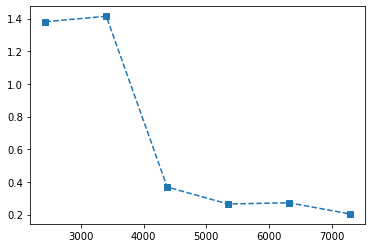

In [20]:
plt.plot(results_qinfer['N_p'], np.sqrt(results_qinfer['mse']), '--s', label='SMC + PL')

In [21]:
results_qinfer.keys()

dict_keys(['loss', 'mse', 'J_hat', 'J_truth_nd', 'xi_J', 'N_p', 'q', 'n_shots', 'data', 'samples', 'A_cr'])

In [22]:
A_cr = results_qinfer['A_cr']

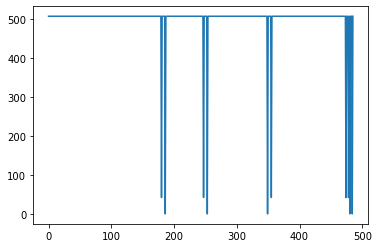

In [23]:
plt.plot(A_cr.action_n_shots)

In [24]:
A_cr = results_qinfer['A_cr']
print(A_cr.action_n_shots)

[507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
  42 507 507 507 507 507   0 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 50

## 4.3 Run on simulator with query constraints

In [25]:
FLAG_simulator = True
readout_noise = ibm_data['misclassif_error']

# Experiment parameters
N_0 = 5*A_cr.N_actions
N_batch = 2*A_cr.N_actions
max_iter = 5

# estimator relevant parameters
n_particles = 5000

learner_expt = QinferExperimentRunner(J_truth_nd, query_space, xi_J, xi_t,
                                      dataset_oracle=oracle_qs_expt, FLAG_simulator=True,
                                      FLAG_readout_noise=True, FLAG_control_noise=True,
                                      readout_noise=readout_noise,
                                      N_0=N_0, N_batch=N_batch, max_iter=max_iter, 
                                      max_shots_query=512, n_particles=n_particles)

shots per query set to 512
Running QinferExperimentRunner with control noise model on!


In [26]:
# Launch the experiment
i_run = 8
np.random.seed(10 * (i_run + 2))

results_qinfer_constraints = learner_expt.AL_runner(log_file='Qinfer_sim_constraints_cr_test.txt')

/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/qinfer_bayesian_learner_dataset.py:217: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  experiment_temp = np.array([(m, u, t, n_shots)], dtype=self.sys_model.expparams_dtype)
/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/qinfer_bayesian_learner_dataset.py:249: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  experiment_temp = np.array([(m, u, t, n_shots)], dtype=self.sys_model.expparams_dtype)
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self.

Active Learning with Qinfer -- Bayes risk query distribution


/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/bayes_risk_heuristic.py:81: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ep_temp = np.array([(m, u, t_nd)], dtype=self._ham_model.expparams_dtype)


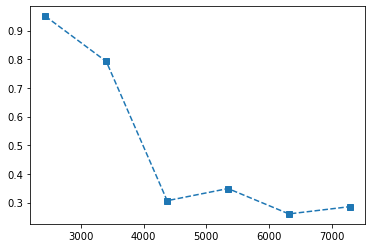

In [27]:
plt.plot(results_qinfer_constraints['N_p'], np.sqrt(results_qinfer_constraints['mse']), '--s', label='SMC + PL')

In [28]:
# Check if a dataset oracle was ever set
learner_expt.dataset_oracle

In [29]:
# Check the action space
A_cr = results_qinfer_constraints['A_cr']

In [30]:
print(A_cr.action_n_shots)

[507  42 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507   0 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507   0 507 507 507 507 507  42 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507 507
 507 507 507 507 507 507 507 507 507 507 507 507 50

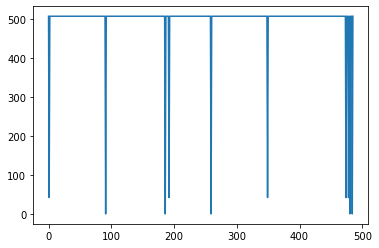

In [32]:
plt.plot(A_cr.action_n_shots)